## Facial keypoints detection

facial keypoint detector based on CNN regressor.




### Load and preprocess data

Script `get_data.py` unpacks data — images and labelled points. 6000 images are located in `images` folder and keypoint coordinates are in `gt.csv` file. Run the cell below to unpack data.

In [0]:
# from get_data import unpack
# unpack('facial-keypoints-data.zip')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
### Useful routines for preparing data
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread,imshow
from skimage.transform import resize,rotate
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [0]:
def visualize_grid(imgs,points,rows,column):
  
  
  
        fig = plt.figure()
        fig.set_size_inches(10,10)
        fig.subplots_adjust(wspace=0.2, hspace=0.2)
         
        for i in range(rows*column):
            ax = fig.add_subplot(rows,column,i+1)
            
         
        for i in range(rows*column):
            fig.axes[i].imshow(imgs[i])
            point = points[i].reshape((14,2))
            x_points = point[:,0]
            y_points = point[:,1]
             
            fig.axes[i].plot(x_points,y_points,'.',color='r')

            
            


In [3]:
def load_imgs_and_keypoints(dirname=r'/content/drive/My Drive/data'):
    
    images_list = sorted(os.listdir(os.path.join(dirname,'images')))
    print(len(images_list))
   
    gt_csv = pd.read_csv(os.path.join(dirname,'gt.csv')).drop('filename',axis=1)
    
   
    points = array(gt_csv.values)
    
    
    image_arr=[]
    i=0
    points_resized = []
    for j,img in enumerate(images_list):
        image_1 =imread(os.path.join(dirname,'images',img)) #/255
        image_arr.append(image_1)
        if j==5999:
          break
        #print(j)   
    print("done")
    return (image_arr,points)
   
imgs,points= load_imgs_and_keypoints() #


6001
done


In [0]:
#convert images,points to dataframe
imgs_points=list(zip(points,imgs))
points_imgs_dataframe = pd.DataFrame(imgs_points,columns=["points","imgs"])

In [0]:
##function to resize points,image
def resize_images_and_keypoints(img,points):
      #print(img.shape)
      image_resized = resize(img, (100, 100),mode='reflect')
      points_resized = (points/img.shape[0])*100
      return image_resized,points_resized
      

In [0]:
image_points_resized = points_imgs_dataframe.apply(lambda x: resize_images_and_keypoints(x["imgs"],x["points"]),axis=1) # ouput series of tuples

In [0]:
imgs_points_resized_dataframe = pd.DataFrame(list(image_points_resized),columns = ["imgs","points"]) #convert back to dataframe

In [0]:
imgs_points_resized_dataframe.to_pickle("/content/drive/My Drive/dataimgs_points_resized_dataframe.pkl") #save dataframe as pickle

## Read data

In [0]:
imgs_points_resized_dataframe_ = pd.read_pickle("/content/drive/My Drive/dataimgs_points_resized_dataframe.pkl") # read pickle

In [0]:
imgs = imgs_points_resized_dataframe_["imgs"]
points = imgs_points_resized_dataframe_["points"]

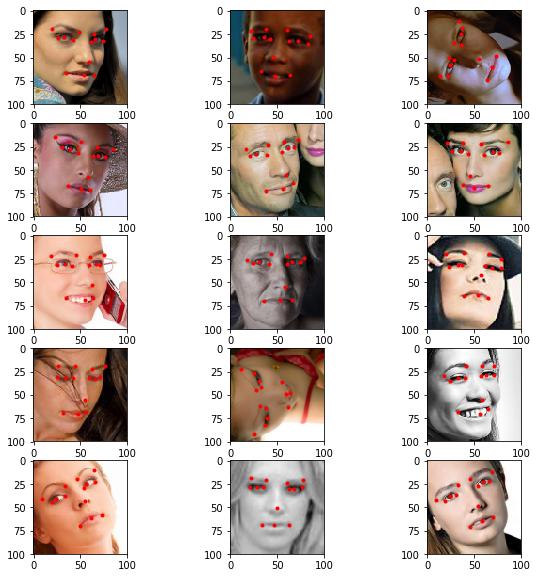

In [9]:
visualize_grid(imgs[0:15], points[0:15],5,3)

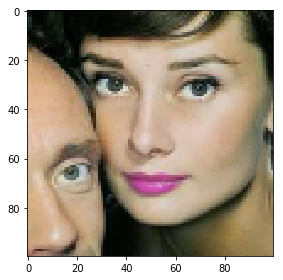

In [6]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[5])


### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

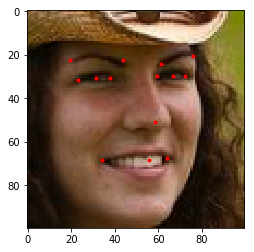

In [7]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    # Write here function which obtains image and normalized
    # coordinates and visualizes points on image
    
    points = points.reshape((14,2))
    x_points = points[:,0]
    y_points = points[:,1]
    #print(x_points,y_points)
    plt.imshow(img)
    plt.plot(x_points,y_points,'.',color='r')
    
    
visualize_points(imgs[599], points[599])

### Remove images of diffrent size

Run the following code to obtain train/validation split for training neural network.

In [0]:
def remove_imgs_of_diiffrent_size (imgs,points):
  img = imgs
  point = points
  points=[]
  imgs = []
  for i,j in enumerate(img):
      try:
        if j.shape[2] == 3:
          imgs.append(j)
          points.append(point[i])

      except:
        pass
  return imgs,points   
imgs,points = remove_imgs_of_diiffrent_size(imgs,points)

##train/valid split######################

In [0]:
from sklearn.model_selection import train_test_split

points = np.vstack(points)
imgs = np.stack(imgs)
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

In [10]:
imgs_train.shape

(5359, 100, 100, 3)

In [11]:
len(points_train)

5359

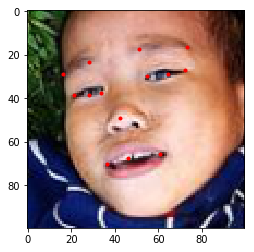

In [12]:
visualize_points(imgs_train[54], points_train[54])

### data augmentation

For better training we will use simple data augmentation — flipping an image and points.function flip_img which flips an image and its' points. 

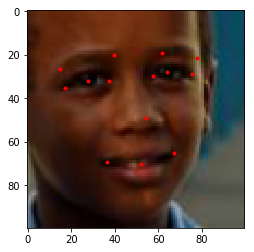

In [13]:

def flip_img(img, points):
    
    img = img[:,::-1,]   #flip image
    
    points = [100-points[i-1] if i%2!=0 else points[i-1] for i in range(1,len(points)+1,1)]
  
    return img,array(points)

f_img, f_points=flip_img(imgs[1], points[1])  
visualize_points(f_img, f_points)


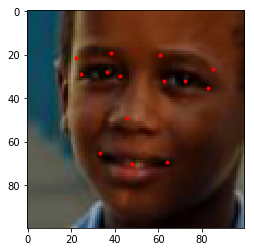

In [64]:
##image before flipping
visualize_points(imgs[1], points[1])

 Apply flip to every image in training sample. As a result  we  obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [0]:

aug_imgs_train=[]
aug_points_train=[]
for i,img in enumerate(imgs_train):
    f_img, f_points=flip_img(img, points_train[i]) 
    aug_imgs_train.append(f_img)
    aug_points_train.append(f_points)
    
    

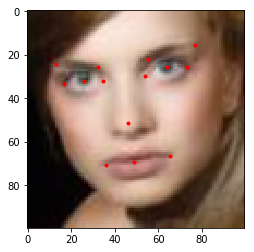

In [15]:
visualize_points(aug_imgs_train[1], aug_points_train[1])

## Add augment data in training Data

In [0]:
aug_imgs,aug_points = remove_imgs_of_diiffrent_size(aug_imgs_train,aug_points_train)
aug_points_train = np.vstack(aug_points+list(points_train))
aug_imgs_train =   np.stack(aug_imgs+list(imgs_train))

In [45]:
aug_imgs_train.shape

(10718, 100, 100, 3)

### Network architecture and training




In [0]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout,BatchNormalization,Activation
)




In [0]:
model = Sequential()
# input layer
model.add(BatchNormalization(input_shape=(100,100,3)))
model.add(Conv2D(32, (3, 3),kernel_initializer='he_normal')) # 100-5+1=96X96X24
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #96-2+1 = 95X95X24
#model.add(Dropout(0.2))

# layer 2
model.add(Conv2D(32, (3, 3))) # 46X46
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2) )) # 46-2+1 = 45X45X36  23X23X36
#model.add(Dropout(0.2))
# layer 3
model.add(Conv2D(64, (3, 3))) # (45-5)/2+1 = 21X21X48  10X10X48
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))# 20X20X48    5X5X48
#model.add(Dropout(0.2))
# # #layer 4
# # model.add(Conv2D(64, (3, 3)))#  8X8X64  
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2))) # 7X7X64
# model.add(Dropout(0.2))

# # # layer 5
#model.add(Conv2D(45, (3, 3))) # 3X3X56
#model.add(Activation('relu'))
model.add(Flatten()) # 504
# layer 6
model.add(Dense(526, activation="relu"))
# layer 7
model.add(Dense(526, activation="relu"))
model.add(Dropout(0.3))
# layer 8
model.add(Dense(28,activation= "relu"))

In [56]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_8 (Batch (None, 100, 100, 3)       12        
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
activation_22 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_23 (Activation)   (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 23, 23, 32)        0         
__________

In [0]:
from keras import optimizers

model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [58]:
history = model.fit(imgs_train[0:9000],points_train[0:9000],validation_split=.3,shuffle=True, 
                 epochs=500)

Train on 3751 samples, validate on 1608 samples
Epoch 1/500
3751/3751 [==============================] - 4s 980us/step - loss: 1585.5895 - acc: 0.3834 - val_loss: 3474.6960 - val_acc: 0.8116
Epoch 2/500
3751/3751 [==============================] - 3s 667us/step - loss: 1381.3754 - acc: 0.5081 - val_loss: 3455.0303 - val_acc: 0.8116
Epoch 3/500
3751/3751 [==============================] - 3s 670us/step - loss: 1393.5630 - acc: 0.5364 - val_loss: 3492.5418 - val_acc: 0.8116
Epoch 4/500
3751/3751 [==============================] - 3s 667us/step - loss: 1374.0830 - acc: 0.5686 - val_loss: 3551.7951 - val_acc: 0.8116
Epoch 5/500
3751/3751 [==============================] - 3s 676us/step - loss: 1296.5732 - acc: 0.6030 - val_loss: 3462.1326 - val_acc: 0.8116
Epoch 6/500
3751/3751 [==============================] - 3s 673us/step - loss: 1283.8237 - acc: 0.6289 - val_loss: 3445.1639 - val_acc: 0.8116
Epoch 7/500
3751/3751 [==============================] - 3s 669us/step - loss: 1237.5323 - acc

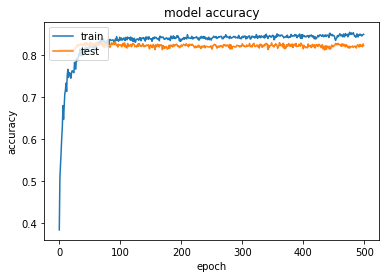

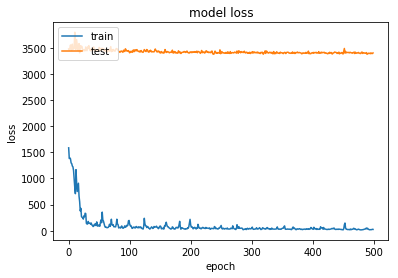

In [66]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# predict points on unseen data
pred = model.predict(imgs_val)


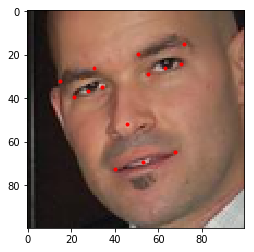

In [61]:
#visualize predicted points
visualize_points(imgs_val[61],pred[61])


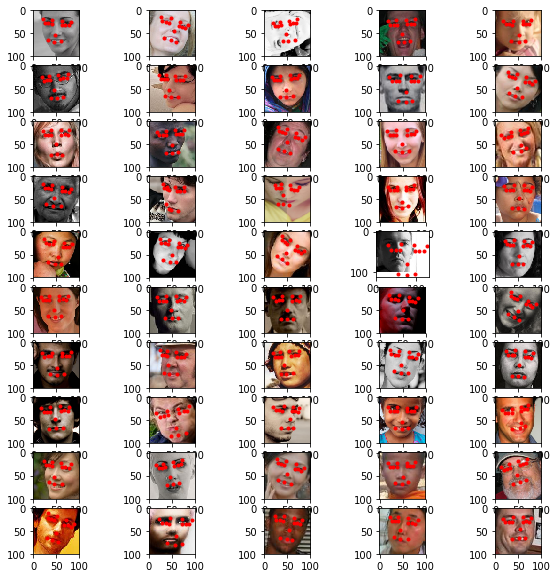

In [67]:
# visualize multiple predicted points
visualize_grid(imgs_val[0:50],pred[0:50],10,5)